In [1]:
from typing import Optional, Union, Iterable, List, Dict

from collections import defaultdict
from functools import reduce
from operator import add

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sbn

from tqdm.notebook import tqdm
from IPython.display import display

import utils.common_utils as cu
import utils.basic_utils as bu
import utils.funcs as fn
import utils.denoising_utils as du
import utils.inpainting_utils as iu
import utils.sr_utils as su
import utils.model_utils as mu
import utils.metric_utils as metu
from utils.paths import ROOT
from utils.keywords import *
from utils.common_types import *

In [2]:
def benchmark_folder(img_stem: str, sigma=None, p=None, zoom=None):
    
    process = bu.get_process(sigma, p, zoom)
    
    folder = ROOT[BENCHMARK][process]
    if process == DENOISING:
        folder = folder[sigma]
    elif process == INPAINTING:
        folder = folder[p]
    if process == SR:
        folder = folder[zoom]
    folder = folder[img_stem]
    
    return folder

In [3]:
def read_benchmark_results(
    img_stem: str,
    sigma=None, p=None, zoom=None,
    noisy: bool = True
) -> DataFrame:
    

    df_low = ROOT[BENCHMARK][LOWPASS_METRICS_CSV].load()
    
    folder = benchmark_folder(img_stem, sigma, p, zoom)
    
    if noisy:
        df = folder[SIMILARITY_METRICS_NOISY_IMG_CSV].load()
    else:
        df = folder[SIMILARITY_METRICS_TRUE_IMG_CSV].load()
    
    df['psd 99_per_bw'] = df_low['psd 99_per_bw']
    
    return df


In [4]:
sigma = 25
p = None
zoom = None
noisy = True


print(f'{noisy = }')

fig, axs = plt.subplots(2, 5, squeeze=True, gridspec_kw={'wspace':0.03, 'hspace':0.31})
axs: List[plt.Axes] = axs.reshape((-1,))

fig.set_size_inches(20, 5)
fig.set_facecolor('white')

if noisy:
        metrics = [
                'best psnr smooth', 
                'psd db strip mse', 
                'psd strip hist emd',
                'psd db mse',
                'psd 99_per_bw'
        ]
else:
        metrics = [
                'psnr increase smooth', 
                'psd db strip mse', 
                'psd strip hist emd',
                'psd db mse',
                'psd 99_per_bw'
        ]

for i, stem in enumerate(BENCHMARK_IMAGES):
        
        df = read_benchmark_results(stem, sigma, p, zoom, noisy=noisy)
        df = df[metrics]

        heatmap = sbn.heatmap(df.corr('kendall'), vmin=-1, vmax=1, annot=True, ax=axs[i])
        
        if i not in (0, 5):
                axs[i].set_yticks([])
        if i not in (5, 6, 7, 8, 9):
                axs[i].set_xticks([])
                
        axs[i].set_title(stem)
    
        plt.tight_layout()
        
        if noisy:
                corr_table = df.corr('kendall')['best psnr smooth']
        else:
                corr_table = df.corr('kendall')['psnr increase smooth']
        
        stem = stem.split('_')[0]
        print(f'{stem: <10} & ', end='')
        
        tmp1 = corr_table['psd db mse']
        tmp2 = corr_table['psd db strip mse']
        tmp3 = corr_table['psd strip hist emd']
        tmp4 = corr_table['psd 99_per_bw']
        
        # print(f'{tmp1:.2f} & {tmp2: >5.2f} & {tmp3: >5.2f} & {tmp4: >5.2f} \\\\\\')
        print(f'{tmp1:.2f} & {tmp2: >5} & {tmp3: >5.2f} & {tmp4: >5.2f} \\\\\\')


# plt.savefig(
# f'{PROCESS}-best-iter-correlations-kendall.jpeg',
# #     'inpainting-best-iter-correlations-kendall.jpeg',
# dpi=200
# )

noisy = True


/tmp/ipykernel_5860/3811452851.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


8          & -0.02 & -0.20022650223192945 & -0.12 & -0.17 \\\
lena       & 0.15 & -0.36695567763143383 & -0.26 & -0.30 \\\
barbara    & 0.05 & -0.1990792831351439 & -0.13 & -0.18 \\\
couple     & 0.12 & -0.361704944073069 & -0.25 & -0.30 \\\


/tmp/ipykernel_22883/4286710163.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


KeyError: 'psnr increase smooth'

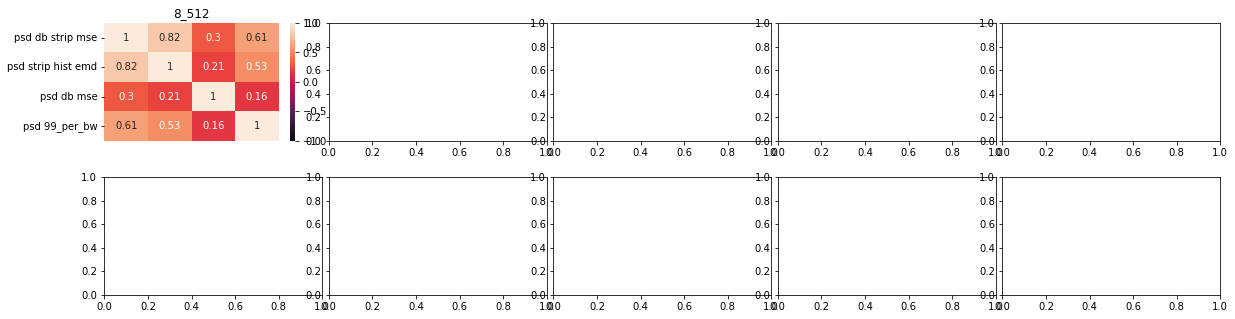

In [ ]:
sigma = 25
p = None
zoom = None
noisy = False


fig, axs = plt.subplots(2, 5, squeeze=True, gridspec_kw={'wspace':0.03, 'hspace':0.31})
axs: List[plt.Axes] = axs.reshape((-1,))

fig.set_size_inches(20, 5)
fig.set_facecolor('white')

metrics = [
        'psd db strip mse', 
        'psd strip hist emd',
        'psd db mse',
        'psd 99_per_bw'
]

for i, stem in enumerate(BENCHMARK_IMAGES):
        
        df = read_benchmark_results(stem, sigma, p, zoom, noisy=noisy)
        df = df[metrics]

        heatmap = sbn.heatmap(df.corr('kendall'), vmin=-1, vmax=1, annot=True, ax=axs[i])
        
        if i not in (0, 5):
                axs[i].set_yticks([])
        if i not in (5, 6, 7, 8, 9):
                axs[i].set_xticks([])
                
        axs[i].set_title(stem)
    
        plt.tight_layout()
        
        if noisy:
                corr_table = df.corr('kendall')['best iteration smooth']
        else:
                corr_table = df.corr('kendall')['psnr increase smooth']
        
        stem = stem.split('_')[0]
        print(f'{stem} & ', end='')
        
        tmp1 = corr_table['psd db mse']
        tmp2 = corr_table['psd db strip mse']
        tmp3 = corr_table['psd strip hist emd']
        tmp4 = corr_table['psd 99_per_bw']
        
        print(f'{tmp1:.2f} & {tmp2:.2f} & {tmp3:.2f} & {tmp4:.2f} \\\\\\')


# plt.savefig(
# f'{PROCESS}-best-iter-correlations-kendall.jpeg',
# #     'inpainting-best-iter-correlations-kendall.jpeg',
# dpi=200
# )

/tmp/ipykernel_30834/2039331535.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


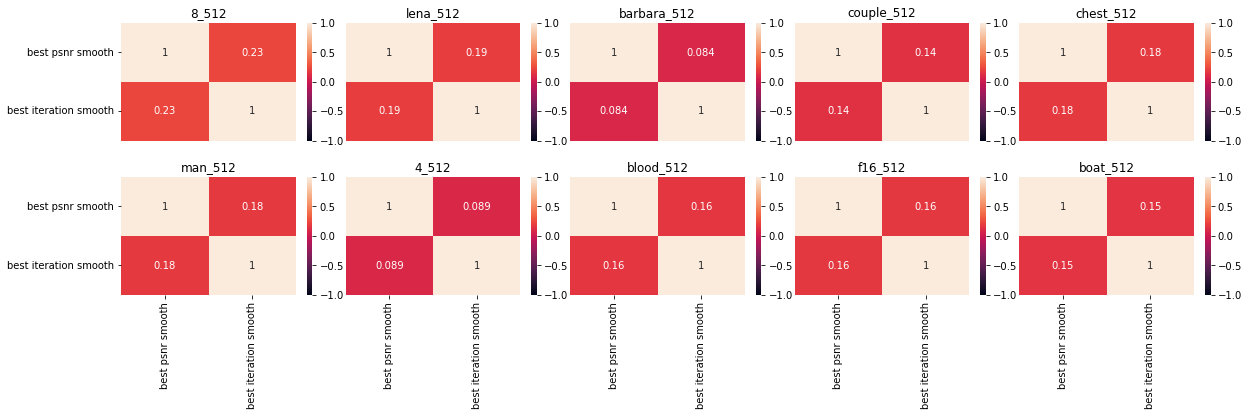

In [5]:
sigma = 25
p = None
zoom = None
noisy = True


fig, axs = plt.subplots(2, 5, squeeze=True, gridspec_kw={'wspace':0.03, 'hspace':0.31})
axs: List[plt.Axes] = axs.reshape((-1,))

fig.set_size_inches(20, 5)
fig.set_facecolor('white')

metrics = [
        'psnr increase smooth', 
        'psd db strip mse', 
        'psd strip hist emd',
        'psd db mse',
        'psd 99_per_bw'
]

for i, stem in enumerate(BENCHMARK_IMAGES):
        df = read_benchmark_results(stem, sigma, p, zoom, noisy=noisy)
        
        cols = df.columns
        # cols = [col for col in cols if col not in ('best psnr', 'best iteration', 'psnr noisy')]
        cols = [col for col in cols if col in ('best psnr smooth', 'best iteration smooth')]
        df = df[cols]
        # df = df[['best psnr smooth', 'best iteration smooth']]

        heatmap = sbn.heatmap(df.corr('kendall'), vmin=-1, vmax=1, annot=True, ax=axs[i])
        
        if i not in (0, 5):
                axs[i].set_yticks([])
        if i not in (5, 6, 7, 8, 9):
                axs[i].set_xticks([])
                
        axs[i].set_title(stem)
    
        plt.tight_layout()


# plt.savefig(
# f'{PROCESS}-best-iter-correlations-kendall.jpeg',
# #     'inpainting-best-iter-correlations-kendall.jpeg',
# dpi=200
# )

In [41]:
metrics = ['psd db mse', 'psd db strip mse', 'psd strip hist emd', 'random mse']
iters = {
    'psd db mse': 9500,
    'psd db strip mse': 9500,
    'psd strip hist emd': 9500,
    'random mse': 9500,
}

In [53]:
folder = ROOT[RANDOM_SEARCH][INPAINTING][50]

df = defaultdict(list)
for stem in tqdm(folder.physical_children()):
    
    df['img_stem'].append(stem)
    
    for metric, iter in iters.items():
        
        try:
            htr = folder[stem][metric]['selected_model']['htr.pkl'].load()
            psnr = htr['best_psnr_gt_sm']
        except FileNotFoundError:
            psnr = None
        df[metric].append(psnr)
        
df = pd.DataFrame.from_dict(df)
df = df.set_index('img_stem')
df = df.sort_index()
display(df)

# cbm3d
df_ds = df.loc[df.index.isin(CBM3D)]
tmp = df_ds.describe().loc['mean']
df_ds.loc['mean'] = tmp
display(df_ds)

# bm3d
df_ds = df.loc[df.index.isin(BM3D)]
tmp = df_ds.describe().loc['mean']
df_ds.loc['mean'] = tmp
display(df_ds)

# set12
df_ds = df.loc[df.index.isin(SET12)]
tmp = df_ds.describe().loc['mean']
df_ds.loc['mean'] = tmp
display(df_ds)

  0%|          | 0/15 [00:00<?, ?it/s]

,psd db mse,psd db strip mse,psd strip hist emd,random mse
img_stem,,,,
barbara_512,None,31.647015,32.378380,32.666814
boat_512,None,33.039975,33.026180,32.357266
cman_256,None,29.490862,29.217343,27.581215
couple_512,None,32.786658,31.697037,32.169297
f16_256,None,29.142277,28.817756,28.921216
fprint_512,None,33.328547,32.590125,32.814128
hill_512,None,32.924793,32.972593,33.505380
house_256,None,37.790015,36.280506,37.812409
lena_512,None,36.287854,36.540105,36.085813


/itet-stor/ozkara/net_scratch/conda_envs/cuda_exp/lib/python3.8/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,psd db mse,psd db strip mse,psd strip hist emd,random mse
img_stem,,,,
mean,NaN,NaN,NaN,NaN


/itet-stor/ozkara/net_scratch/conda_envs/cuda_exp/lib/python3.8/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,psd db mse,psd db strip mse,psd strip hist emd,random mse
img_stem,,,,
barbara_512,None,31.647015,32.378380,32.666814
boat_512,None,33.039975,33.026180,32.357266
cman_256,None,29.490862,29.217343,27.581215
couple_512,None,32.786658,31.697037,32.169297
fprint_512,None,33.328547,32.590125,32.814128
hill_512,None,32.924793,32.972593,33.505380
house_256,None,37.790015,36.280506,37.812409
lena_512,None,36.287854,36.540105,36.085813
man_512,None,32.622502,32.915931,32.088778


/itet-stor/ozkara/net_scratch/conda_envs/cuda_exp/lib/python3.8/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,psd db mse,psd db strip mse,psd strip hist emd,random mse
img_stem,,,,
barbara_512,None,31.647015,32.378380,32.666814
boat_512,None,33.039975,33.026180,32.357266
cman_256,None,29.490862,29.217343,27.581215
couple_512,None,32.786658,31.697037,32.169297
f16_256,None,29.142277,28.817756,28.921216
house_256,None,37.790015,36.280506,37.812409
lena_512,None,36.287854,36.540105,36.085813
man_512,None,32.622502,32.915931,32.088778
monar_256,None,31.820910,31.408322,32.305913


In [5]:
metrics = ['psd db mse', 'psd db strip mse', 'psd strip hist emd', 'random mse']
iters = {
    'psd db mse': 4000,
    'psd db strip mse': 4000,
    'psd strip hist emd': 4000,
    'random mse': 4000,
}
folder = ROOT[RANDOM_SEARCH][SR][4]
df = defaultdict(list)
for stem in tqdm(folder.physical_children()):
    
    df['img_stem'].append(stem)
    
    for metric, iter in iters.items():
        
        try:
            htr = folder[stem][metric]['selected_model']['htr.pkl'].load()
            psnr_gt_sm = htr['psnr_gt_sm']
            psnr = psnr_gt_sm[iter]
        except FileNotFoundError:
            psnr = None
        df[metric].append(psnr)
        
df = pd.DataFrame.from_dict(df)
df = df.set_index('img_stem')
display(df)

# bm3d
df_bm3d = df.loc[df.index.isin(BM3D)]
tmp = df_bm3d.describe().loc['mean']
df_bm3d.loc['mean'] = tmp
display(df_bm3d)

# cbm3d
df_cbm3d = df.loc[df.index.isin(CBM3D)]
tmp = df_cbm3d.describe().loc['mean']
df_cbm3d.loc['mean'] = tmp
display(df_cbm3d)

# set12
df_set12 = df.loc[df.index.isin(SET12)]
tmp = df_set12.describe().loc['mean']
df_set12.loc['mean'] = tmp
display(df_set12)

  0%|          | 0/5 [00:00<?, ?it/s]

,psd db mse,psd db strip mse,psd strip hist emd,random mse
img_stem,,,,
bird_rgb,NaN,NaN,NaN,NaN
butterfly_rgb,NaN,NaN,NaN,NaN
baby_rgb,NaN,NaN,NaN,NaN
woman_rgb,26.954324,26.690631,27.568266,24.439883
head_rgb,27.540007,29.083755,28.485882,29.252264


/itet-stor/ozkara/net_scratch/conda_envs/cuda_exp/lib/python3.8/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,psd db mse,psd db strip mse,psd strip hist emd,random mse
img_stem,,,,
mean,NaN,NaN,NaN,NaN


/itet-stor/ozkara/net_scratch/conda_envs/cuda_exp/lib/python3.8/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,psd db mse,psd db strip mse,psd strip hist emd,random mse
img_stem,,,,
mean,NaN,NaN,NaN,NaN


/itet-stor/ozkara/net_scratch/conda_envs/cuda_exp/lib/python3.8/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,psd db mse,psd db strip mse,psd strip hist emd,random mse
img_stem,,,,
mean,NaN,NaN,NaN,NaN


In [19]:
df_ds = pd.DataFrame(df)
for ds_name, ds in DENOISING_DATASETS.items():
    
    tmp = df.loc[df.index.isin(ds)]
    tmp = tmp.describe()
    
    df_ds.loc[ds_name] = tmp.loc['mean']
    

In [20]:


df = defaultdict(list)
ds = reduce(add, (SET12, ))
for stem in tqdm(folder.physical_children()):
    
    df['img_stem'].append(stem)
    
    for metric, iter in iters.items():
        
        try:
            htr = folder[stem][metric]['selected_model']['htr.pkl'].load()
            best_iter_sm = htr['best_iter_sm']
        except FileNotFoundError:
            best_iter_sm = None
        df[metric].append(best_iter_sm)
        
df = pd.DataFrame.from_dict(df)
df = df.set_index('img_stem')
display(df)
display(df.describe())

  0%|          | 0/24 [00:00<?, ?it/s]

,psd db mse,psd db strip mse,psd strip hist emd,random mse
img_stem,,,,
hill_512,NaN,1358,749.0,448.0
couple_512,NaN,1400,1080.0,462.0
cman_256,624.0,986,1211.0,484.0
monar_256,NaN,732,2999.0,NaN
montage_256,594.0,643,512.0,1139.0
kodim01_rgb,NaN,2999,NaN,NaN
man_512,NaN,2998,2943.0,738.0
house_256,513.0,1071,1243.0,314.0
lena_512_rgb,NaN,2999,1208.0,NaN


,psd db mse,psd db strip mse,psd strip hist emd,random mse
count,4.00000,24.000000,18.000000,15.000000
mean,667.50000,1490.833333,1594.000000,770.200000
std,186.97326,761.498903,906.254671,375.165906
min,513.00000,533.000000,512.000000,314.000000
25%,573.75000,990.500000,1082.500000,473.000000
50%,609.00000,1263.000000,1227.000000,674.000000
75%,702.75000,1874.000000,2413.750000,1019.000000
max,939.00000,2999.000000,2999.000000,1684.000000


In [64]:
df.describe()

,psd db mse,psd db strip mse,psd strip hist emd,random mse
count,4.00000,9.000000,5.000000,4.000000
mean,667.50000,1301.666667,1313.000000,573.750000
std,186.97326,709.129925,1000.983267,383.658159
min,513.00000,643.000000,512.000000,314.000000
25%,573.75000,986.000000,600.000000,347.000000
50%,609.00000,1071.000000,1211.000000,421.000000
75%,702.75000,1400.000000,1243.000000,647.750000
max,939.00000,2998.000000,2999.000000,1139.000000


In [12]:
display(iters)
display(iters.keys())

folder = ROOT[RANDOM_SEARCH][DENOISING][25]

bm3d_psnrs = defaultdict(list)
cbm3d_psnrs = defaultdict(list)
set12_psnrs = defaultdict(list)

for stem in folder.physical_children():
    
    for metric, iter in iters.items():
        
        try:
            htr = folder[stem][metric]['selected_model']['htr.pkl'].load()
            psnr_gt_sm = htr['psnr_gt_sm']
            best_iter_sm = htr['best_iter_sm']
            psnr = psnr_gt_sm[iter]
            
            if stem in BM3D:
                bm3d_psnrs[metric].append(psnr)
            if stem in CBM3D:
                cbm3d_psnrs[metric].append(psnr)
            if stem in SET12:
                set12_psnrs[metric].append(psnr)
                
        except FileNotFoundError:
            psnr = 0
            
for ds in ('BM3D', 'CBM3D', 'SET12'):
    print(f'{ds: >10}:   ', end='')
    
    for metric, iter in iters.items():
        
        if ds == 'BM3D':
            avg = bm3d_psnrs[metric]
        elif ds == 'CBM3D':
            avg = cbm3d_psnrs[metric]
        elif ds == 'SET12':
            avg = set12_psnrs[metric]
            
        avg = sum(avg) / len(avg)
            
        print(f'{avg: >5.2f} & ', end='')
    
    print()

{'psd db mse': 1200,
 'psd db strip mse': 1200,
 'psd strip hist emd': 1500,
 'random mse': 1200}

dict_keys(['psd db mse', 'psd db strip mse', 'psd strip hist emd', 'random mse'])

      BM3D:   26.17 & 27.43 & 25.88 & 23.61 & 
     CBM3D:   28.26 & 29.86 & 27.91 & 28.26 & 
     SET12:   25.99 & 26.97 & 26.25 & 23.37 & 
